In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as K

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report, RocCurveDisplay

from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

2024-11-26 23:47:33.684597: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 23:47:33.693274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732682853.702941   94649 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732682853.705846   94649 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 23:47:33.716530: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Preparation for trainning - Train Split

In [3]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image After Data Augmentation, Image Size 224x224/')

In [4]:
batch_size_n = 32

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 6106 files for training.


I0000 00:00:1732682855.331360   94649 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
classes_ = train_ds.class_names
classes_

['Density1Benign',
 'Density1Malignant',
 'Density2Benign',
 'Density2Malignant',
 'Density3Benign',
 'Density3Malignant',
 'Density4Benign',
 'Density4Malignant']

In [7]:
classes_ = train_ds.class_names
len(classes_)

8

In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 7632 files belonging to 8 classes.
Using 1526 files for validation.


In [9]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

train_ds, val_ds

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Preparation for trainning - Test Split

In [10]:
path = os.path.realpath('data/Dataset of Breast mammography images with Masses')
list_path = path.split('/')
list_path.remove('notebooks')
list_path.remove('breast-cancer-project')
path = os.path.join('/'.join(list_path), 'Image Before Data Augmentation, Image Size 224x224/')

In [11]:
train_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 170 files for training.


In [12]:
val_ds_test = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size_n,
)

Found 212 files belonging to 8 classes.
Using 42 files for validation.


In [13]:
def normalize(image, label):
  return tf.cast(image/255., tf.float32), label

train_ds_test = train_ds_test.map(normalize)
val_ds_test = val_ds_test.map(normalize)

train_ds_test, val_ds_test

(<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

# Training

In [14]:
from tensorflow.keras import mixed_precision


mixed_precision.set_global_policy('mixed_float16')

In [15]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

I0000 00:00:1732682856.340752   94649 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1756 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
with session.as_default():
    base_model = EfficientNetV2B0(weights=None, include_top=True, input_shape=(224, 224, 3), classes=8)
    x = base_model.output
    x = Flatten()(x)
    last_layer = Dense(8, activation='softmax')(x)

2024-11-26 23:47:36.353985: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


In [17]:
model = tf.keras.Model(inputs=base_model.input, outputs=last_layer)

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='SparseCategoricalCrossentropy',
              auto_scale_loss='True',
              metrics=['accuracy'])

In [19]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    batch_size=batch_size_n,
                    epochs=epochs)

Epoch 1/50


I0000 00:00:1732682880.574774   94748 service.cc:148] XLA service 0x7f4ea0022c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732682880.575113   94748 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-26 23:48:01.109000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732682889.097568   94748 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-26 23:48:26.074464: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,112,112,32]{3,2,1,0}, f16[32,112,112,16]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_resul

190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2637 - loss: 1.9355

2024-11-26 23:49:23.821506: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[16,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[26,112,112,32]{3,2,1,0}, f16[26,112,112,16]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-11-26 23:49:23.979177: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.182417737s
Trying algorithm eng0{} for conv (f16[16,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[26,112,112,32]{3,2,1,0}, f16[26,112,112,16]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"act

191/191 ━━━━━━━━━━━━━━━━━━━━ 148s 376ms/step - accuracy: 0.2640 - loss: 1.9351 - val_accuracy: 0.3028 - val_loss: 1.8558
Epoch 2/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.3048 - loss: 1.8293 - val_accuracy: 0.3028 - val_loss: 1.8041
Epoch 3/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3015 - loss: 1.7907 - val_accuracy: 0.3028 - val_loss: 1.7799
Epoch 4/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3068 - loss: 1.7729 - val_accuracy: 0.3028 - val_loss: 1.7643
Epoch 5/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.3019 - loss: 1.7607 - val_accuracy: 0.3028 - val_loss: 1.7636
Epoch 6/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.2980 - loss: 1.7596 - val_accuracy: 0.3028 - val_loss: 1.7605
Epoch 7/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.3059 - loss: 1.7568 - val_accuracy: 0.3028 - val_loss: 1.7582
Epoch 8/50
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.3049 - loss: 1.7471 - val_accur

# Evaluating

In [20]:
history.history

{'accuracy': [0.2869308888912201,
  0.30085161328315735,
  0.29905012249946594,
  0.30363577604293823,
  0.2987225651741028,
  0.2997052073478699,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.3013429343700409,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0.30167049169540405,
  0

In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c

 Total params: 17,667,686 (67.40 MB)

 Trainable params: 5,869,024 (22.39 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 11,738,054 (44.78 MB)

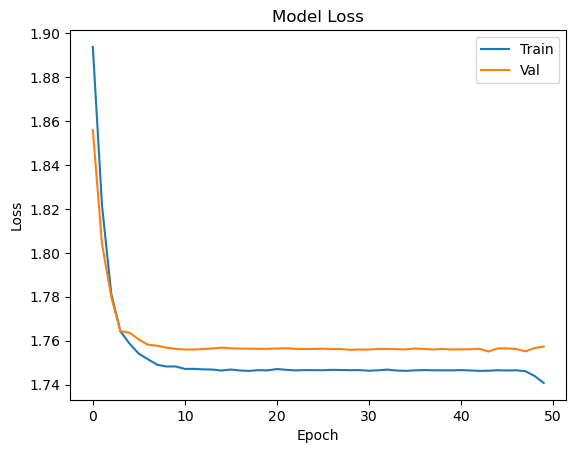

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

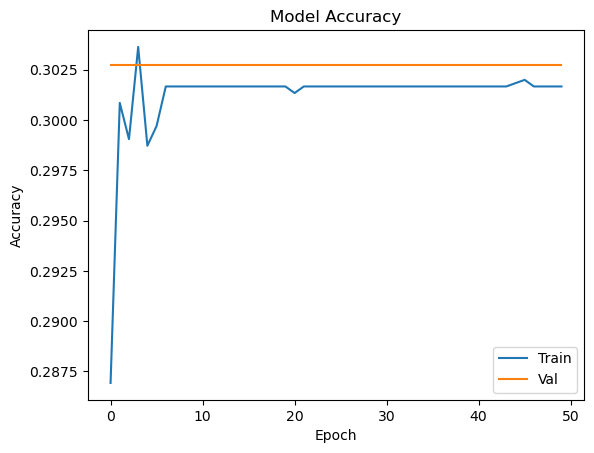

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)

48/48 - 1s - 16ms/step - accuracy: 0.3028 - loss: 1.7573


In [25]:
print(test_acc)

0.302752286195755


In [26]:
predictions = model.predict(train_ds_test)
val_pred = np.argmax(predictions, axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


In [27]:
y_true = []
y_pred = []
for images, labels in val_ds_test:
  # Make predictions on the batch
  batch_pred = model.predict(images)
  y_pred.extend(list(batch_pred.argmax(axis=1)))  # Predicted labels
  y_true.extend(list(labels.numpy()))  # True labels from the batch

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2024-11-26 23:59:36.182412: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


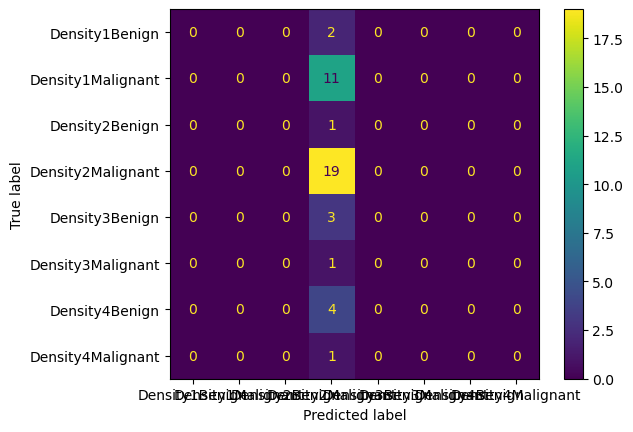

In [28]:
disp = ConfusionMatrixDisplay(cm, display_labels=classes_,)
disp.plot()

In [29]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00        11
           2       0.00      0.00      0.00         1
           3       0.45      1.00      0.62        19
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         1

    accuracy                           0.45        42
   macro avg       0.06      0.12      0.08        42
weighted avg       0.20      0.45      0.28        42



/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/viviane/apps/anaconda3/envs/pro1-cnn/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

# Save

In [30]:
# model.save('models/breast_cancer_classification-efficientnet.h5')